#  F1 Teammate Battle
**Project Team Roster**

*   **Data Acquisition & Cleaning**
    *   `@Abay Khamzin` — *Sourcing raw data and scrubbing anomalies.*
*   **Feature Engineering**
    *   `@Ibrahhim Tlektes` — *Creating the logic behind driver duels.*
*   **Model Training**
    *   `@Timur Shermukhamedov` — *Training Random Forest & Logistic Regression.*
*   **Exploratory Data Analysis**
    *   `@Nazerke Abdirova` — *Visualizing insights and finding patterns.*



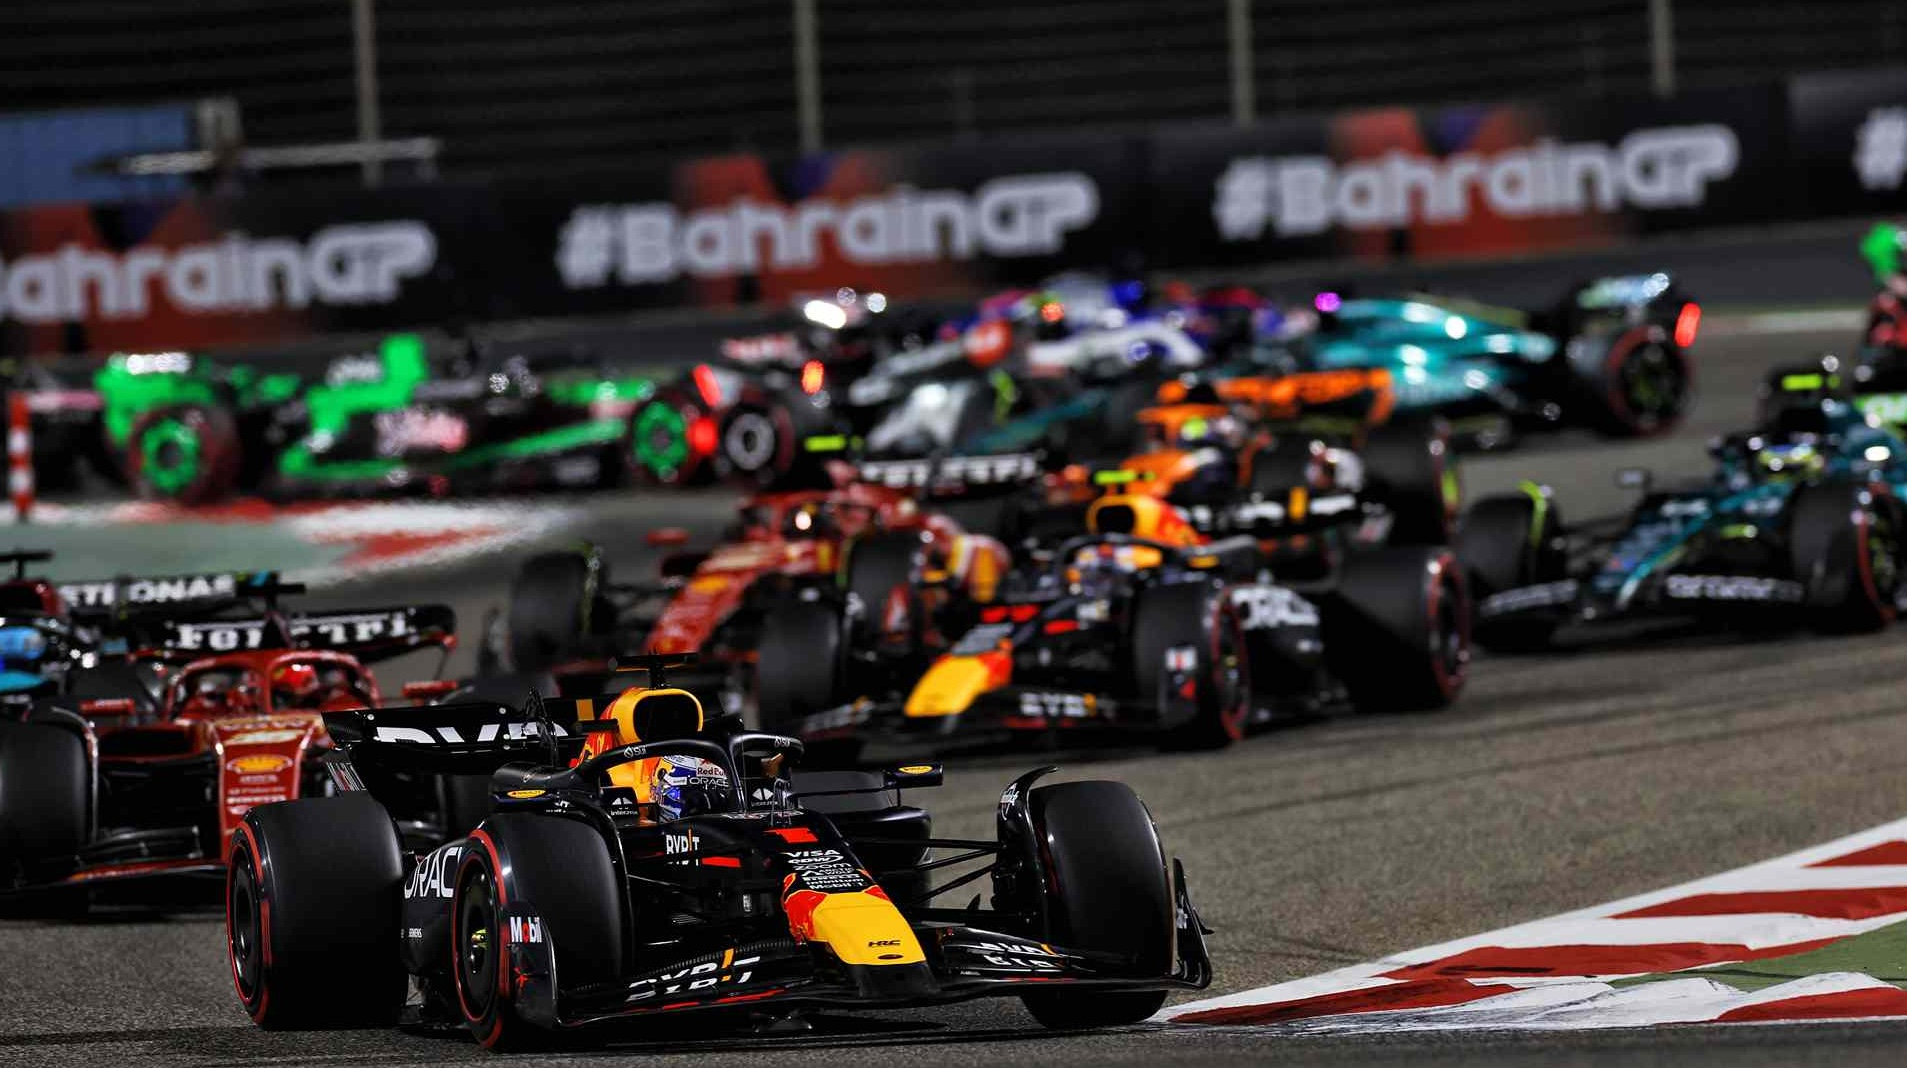

In [ ]:
import pandas as pd
import numpy as np

    # 1. Load raw data
all_data = []
years = [2021, 2022, 2023, 2024, 2025]

for year in years:
    file = f'f1_{year}_raw.csv'
    df = pd.read_csv(file)
    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)

final_df.head()

print(f"Initial number of rows: {len(final_df)}")

# 2. Convert data types (just in case)
# There may be 'NC' (Not Classified) or strings, convert to numbers
cols_to_numeric = ['QualiPos', 'GridPosition', 'ClassifiedPosition']

for col in cols_to_numeric:
    # errors='coerce' will turn everything that's not a number (e.g. 'NC') into NaN
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

# 3. Filtering: Keep only those who finished
# Usually finish status is 'Finished' or '+1 Lap', '+2 Laps', etc.
# The simplest way: check that ClassifiedPosition is a number (not NaN)
# And status does not contain words 'Collision', 'Accident', 'Spun', 'Engine'
# But it's easiest to trust ClassifiedPosition.

df_clean = final_df.dropna(subset=['ClassifiedPosition', 'QualiPos', 'GridPosition'])

# Additional status check (optional, but reliable)
# Keep only those whose status looks like a finish
valid_status = df_clean['Status'].astype(str).str.contains(r'Finished|\+\d', regex=True)
df_clean = df_clean[valid_status]
df_clean.to_csv('f1_all_clean_data.csv', index=False)

print(f"Rows after cleaning (only finishers): {len(df_clean)}")

Исходное количество строк: 1738
Строк после очистки (только финишировавшие): 1253


New Features

In [ ]:
import pandas as pd
RAW_PATH = "f1_all_clean_data.csv"
TRAIN_PATH = "f1_teammate_pairs.csv"

df = pd.read_csv(RAW_PATH)

# ===========================
# 2. REMOVE DNF
# ===========================
df = df[df["Status"].isin(["Finished", "+1 Lap"])]

# ===========================
# 3. POINTS PER RACE
# ===========================
points_map = {1:25, 2:18, 3:15, 4:12, 5:10, 6:8, 7:6, 8:4, 9:2, 10:1}
df["RacePoints"] = df["ClassifiedPosition"].map(points_map).fillna(0)

# ===========================
# 4. CUMULATIVE POINTS
# ===========================
df = df.sort_values(["Year", "Round"])
df["PointsUntilRace"] = df.groupby(["Year", "Abbreviation"])["RacePoints"].cumsum() - df["RacePoints"]

# ===========================
# 5. EXPERIENCE
# ===========================
first_year = df.groupby("Abbreviation")["Year"].min()
df["Experience"] = df.apply(lambda r: r["Year"] - first_year[r["Abbreviation"]], axis=1)

# ===========================
# 6. TRACK TYPE
# ===========================
street = ["Monaco", "Baku", "Jeddah", "Singapore", "Las Vegas", "Miami"]
semi = ["Australia", "Canada", "Saudi Arabia", "Qatar"]

def get_track_type(track):
    if track in street:
        return "street"
    if track in semi:
        return "semi"
    return "permanent"

df["TrackType"] = df["Circuit"].apply(get_track_type)

# ===========================
# 7. FAVORITE TRACK 
# ===========================
avg_finish = df.groupby(["Abbreviation", "Circuit"])["ClassifiedPosition"].mean().reset_index()
avg_finish = avg_finish.rename(columns={"ClassifiedPosition": "AvgFinish"})
df = df.merge(avg_finish, on=["Abbreviation", "Circuit"], how="left")

# ===========================
# 8. GENERATE DRIVER PAIRS
# ===========================
pairs = []

for (year, rnd, team), group in df.groupby(["Year", "Round", "TeamName"]):
    if len(group) != 2:
        continue

    d1, d2 = group.iloc[0], group.iloc[1]

    def make_pair(a, b):
        return {
            "Year": year,
            "Round": rnd,
            "Circuit": a["Circuit"],
            "TeamName": team,
            "DriverA": a["Abbreviation"],
            "DriverB": b["Abbreviation"],

            "Quali_Delta": a["QualiPos"] - b["QualiPos"],
            "Grid_Delta": a["GridPosition"] - b["GridPosition"],
            "Points_Delta": a["PointsUntilRace"] - b["PointsUntilRace"],
            "Experience_Delta": a["Experience"] - b["Experience"],
            "FavoriteTrackAdvantage": a["AvgFinish"] - b["AvgFinish"],
            "TrackType": a["TrackType"],

            "Target": 1 if a["ClassifiedPosition"] < b["ClassifiedPosition"] else 0
        }

    pairs.append(make_pair(d1, d2))
    
    # mirror pair
    pairs.append(make_pair(d2, d1))

pairs_df = pd.DataFrame(pairs)
pairs_df.to_csv(TRAIN_PATH, index=False)





ML Modeling

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ==========================================
# 1. LOAD TEAMMATE DATA
# ==========================================
# We load the file created by Role #2 (TRAIN_PATH)
# Make sure your teammate saved the file as "f1_teammate_pairs.csv"
pairs_df = pd.read_csv("f1_teammate_pairs.csv")

print("Data loaded!")
print(f"Total pairs (battles): {pairs_df.shape[0]}")
print("Sample data:")
display(pairs_df.head()) # In Jupyter this shows a nice table

# ==========================================
# 2. PREPROCESSING (Encoding)
# ==========================================
# We have a text column 'TrackType' (street, semi, permanent).
# ML doesn't understand text, convert to numbers (One-Hot Encoding).
ml_df = pd.get_dummies(pairs_df, columns=['TrackType'], drop_first=True)

# Fill possible missing values with zeros
ml_df = ml_df.fillna(0)

# ==========================================
# 3. FEATURE SELECTION
# ==========================================
# We don't use 'Year', 'Round', 'DriverA' for training — these are metadata.
# We only need the deltas and track characteristics.

feature_cols = [
    'Quali_Delta',           # Qualifying position difference
    'Grid_Delta',            # Starting grid difference (penalties included)
    'Points_Delta',          # Psychological advantage (points)
    'Experience_Delta',      # Experience difference
    'FavoriteTrackAdvantage' # How much the driver likes this track
]

# Add columns created from TrackType (e.g., TrackType_street)
feature_cols += [col for col in ml_df.columns if 'TrackType_' in col]

target_col = 'Target' # 1 if driver A won, 0 if B

print(f"\nFeatures for training: {feature_cols}")

# ==========================================
# 4. TRAIN / TEST SPLIT (by year)
# ==========================================
# Train on the past (2021-2023), test on the future (2024)
last_year = ml_df['Year'].max()

train_df = ml_df[ml_df['Year'] < last_year]
test_df = ml_df[ml_df['Year'] == last_year]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\nTraining set (up to {last_year}): {X_train.shape[0]} rows")
print(f"Test set (season {last_year}): {X_test.shape[0]} rows")

# ==========================================
# 5. SCALING
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 6. BASELINE (What do we compare to?)
# ==========================================
# Simple strategy: "Bet on the one who qualified higher"
# If Quali_Delta < 0, driver A started higher -> predict 1.
y_pred_baseline = (test_df['Quali_Delta'] < 0).astype(int)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print(f"\n--- RESULTS ---")
print(f"Baseline Accuracy (just by quali): {baseline_acc:.2%}")

# ==========================================
# 7. MODEL TRAINING
# ==========================================

# --- Logistic Regression ---
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1] # Probabilities for ROC-AUC

# ==========================================
# 8. METRICS AND CONCLUSIONS
# ==========================================

print(f"Logistic Regression Accuracy:        {accuracy_score(y_test, y_pred_lr):.2%}")
print(f"Random Forest Accuracy:              {accuracy_score(y_test, y_pred_rf):.2%}")

# ROC AUC for Random Forest
print(f"Random Forest ROC-AUC:               {roc_auc_score(y_test, y_prob_rf):.3f}")

# Feature importance (to show what influences winning)
importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nWhat matters most for beating a teammate?")
display(importances)

# Save the final file for the analyst (Role #4)
results = test_df.copy()
results['Predicted_Winner'] = y_pred_rf
results['Real_Winner'] = y_test
results.to_csv("f1_ml_results.csv", index=False)
print("\nPrediction file 'f1_ml_results.csv' saved.")

Data loaded!
Total pairs (battles): 1004
Sample data:


Year  Round Circuit           TeamName DriverA DriverB  Quali_Delta  \
0  2021      1  Sakhir  Alfa Romeo Racing     RAI     GIO          2.0   
1  2021      1  Sakhir  Alfa Romeo Racing     GIO     RAI         -2.0   
2  2021      1  Sakhir       Aston Martin     STR     VET         -8.0   
3  2021      1  Sakhir       Aston Martin     VET     STR          8.0   
4  2021      1  Sakhir            Ferrari     LEC     SAI         -4.0   

   Grid_Delta  Points_Delta  Experience_Delta  FavoriteTrackAdvantage  \
0         2.0           0.0                 0                    -1.0   
1        -2.0           0.0                 0                     1.0   
2       -10.0           0.0                 0                    -4.0   
3        10.0           0.0                 0                     4.0   
4        -4.0           0.0                 0                    -0.5   

   TrackType  Target  
0  permanent       1  
1  permanent       0  
2  permanent       1  
3  permanent       0  
4  permanent       1


Features for training: ['Quali_Delta', 'Grid_Delta', 'Points_Delta', 'Experience_Delta', 'FavoriteTrackAdvantage', 'TrackType_street']

Training set (up to 2025): 826 rows
Test set (season 2025): 178 rows

--- RESULTS ---
Baseline Accuracy (just by quali): 73.03%
Logistic Regression Accuracy:        82.02%
Random Forest Accuracy:              84.27%
Random Forest ROC-AUC:               0.871

What matters most for beating a teammate?


Feature  Importance
4  FavoriteTrackAdvantage    0.498930
0             Quali_Delta    0.264972
1              Grid_Delta    0.158060
2            Points_Delta    0.058072
3        Experience_Delta    0.014789
5        TrackType_street    0.005177


Prediction file 'f1_ml_results.csv' saved.


Some Graphics

Data found in memory.


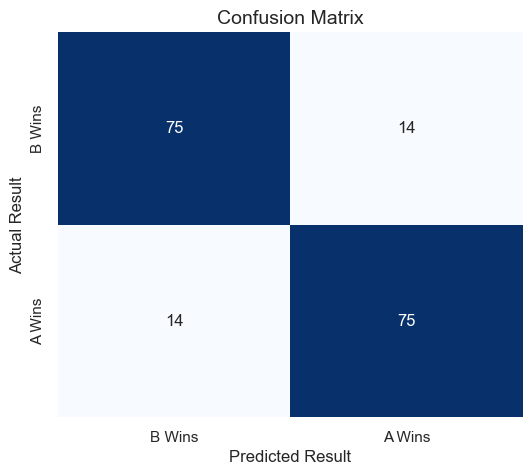

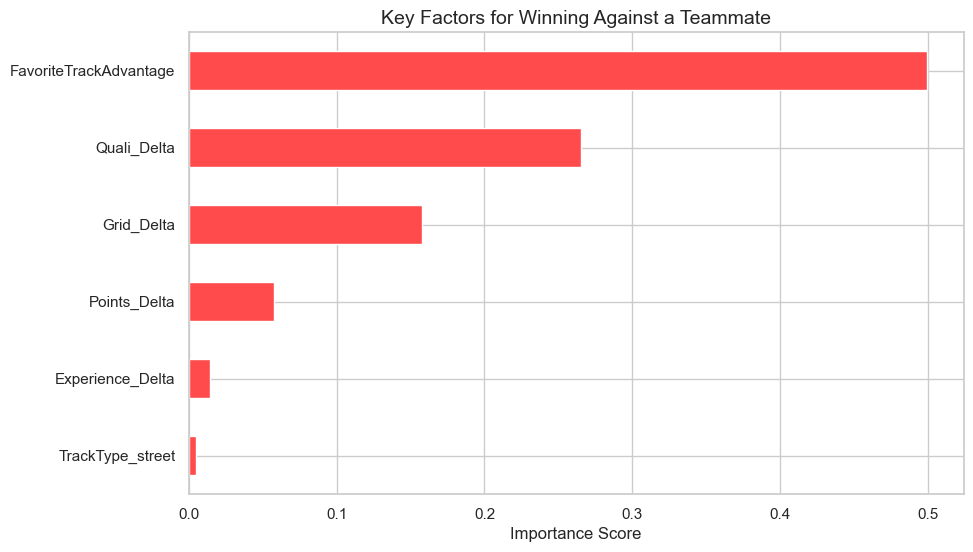

Most active battle in test set: Ferrari (LEC vs HAM) - 30 races


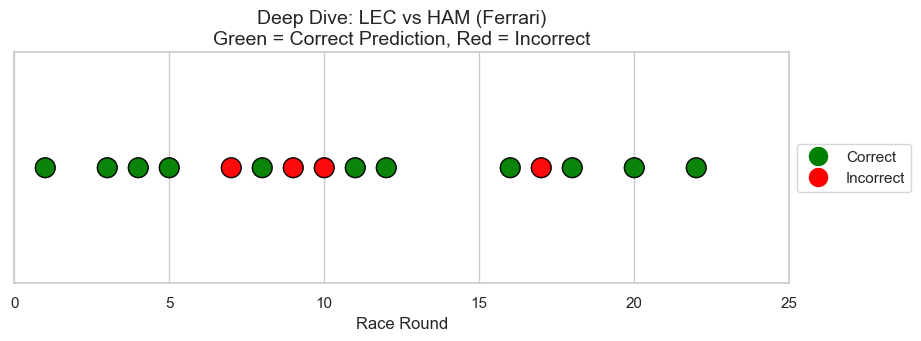

Model accuracy for Ferrari: 22/30 (73.3%)


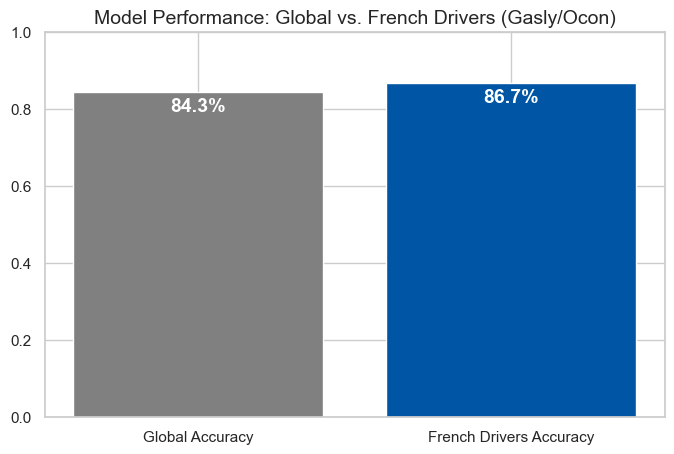

In [25]:
# ==========================================
# PART 4: VISUALIZATION & ANALYTICS (Role #4)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- FIX: Load data if 'results' is missing ---
try:
    results.head()
    print("Data found in memory.")
except NameError:
    print("Variable 'results' not found. Loading from 'f1_ml_results.csv'...")
    try:
        results = pd.read_csv("f1_ml_results.csv")
        print("Data loaded successfully!")
    except FileNotFoundError:
        print("ERROR: File 'f1_ml_results.csv' not found. Please run Part 3 (ML Modeling) first!")

# -------------------------------------------------------
# PLOT 1: Confusion Matrix
# -------------------------------------------------------
if 'results' in locals():
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(results['Real_Winner'], results['Predicted_Winner'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['B Wins', 'A Wins'],
                yticklabels=['B Wins', 'A Wins'])
    plt.title('Confusion Matrix', fontsize=14)
    plt.ylabel('Actual Result')
    plt.xlabel('Predicted Result')
    plt.show()

# -------------------------------------------------------
# PLOT 2: Feature Importance
# -------------------------------------------------------
# This plot requires the trained model 'rf'. If you restarted the notebook, 'rf' is gone.
try:
    feat_importances = pd.Series(rf.feature_importances_, index=feature_cols)
    
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(10).sort_values().plot(kind='barh', color='#FF4B4B') 
    plt.title('Key Factors for Winning Against a Teammate', fontsize=14)
    plt.xlabel('Importance Score')
    plt.show()
except NameError:
    print("\n[INFO] Skipping Feature Importance Plot.")
    print("Reason: The trained model 'rf' is not in memory. Run Part 3 to see this plot.")

# -------------------------------------------------------
# PLOT 3: ALPINE CIVIL WAR
# -------------------------------------------------------

if 'results' in locals():
    # 1. Find the team with the highest number of entries in the test set
    top_team = results['TeamName'].value_counts().idxmax()
    battles_count = results['TeamName'].value_counts().max()
    
    # 2. Filter data for this team only
    team_data = results[results['TeamName'] == top_team]
    
    # 3. Identify the drivers
    d1 = team_data['DriverA'].iloc[0]
    d2 = team_data['DriverB'].iloc[0]
    
    print(f"Most active battle in test set: {top_team} ({d1} vs {d2}) - {battles_count} races")

    # 4. Create the plot
    plt.figure(figsize=(10, 3))
    
    # Logic: Green = Correct Prediction, Red = Incorrect Prediction
    colors = np.where(team_data['Real_Winner'] == team_data['Predicted_Winner'], 'green', 'red')
    
    # Draw scatter points
    plt.scatter(team_data['Round'], [1]*len(team_data), 
                c=colors, s=200, edgecolors='black', alpha=0.8)
    
    # Styling the plot
    plt.title(f'Deep Dive: {d1} vs {d2} ({top_team})\nGreen = Correct Prediction, Red = Incorrect', fontsize=14)
    plt.xlabel('Race Round')
    plt.yticks([]) # Hide Y-axis as it represents a single timeline
    plt.xlim(0, 25) # Adjust X-axis to fit a standard season
    
    # Add Legend manually
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Correct', markersize=15),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Incorrect', markersize=15)]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    # Print statistics
    correct = (team_data['Real_Winner'] == team_data['Predicted_Winner']).sum()
    print(f"Model accuracy for {top_team}: {correct}/{battles_count} ({correct/battles_count:.1%})")

else:
    print("Error: 'results' DataFrame not found in memory.")


# -------------------------------------------------------
# PLOT 4: FRENCH LEGION ANALYSIS (Gasly & Ocon)
# -------------------------------------------------------
if 'results' in locals():
    french_drivers = ['GAS', 'OCO']

    # Filter rows where at least one driver is French
    is_french_battle = results['DriverA'].isin(french_drivers) | results['DriverB'].isin(french_drivers)
    french_df = results[is_french_battle].copy()

    if not french_df.empty:
        # Calculate accuracy specifically for this group
        french_acc = accuracy_score(french_df['Real_Winner'], french_df['Predicted_Winner'])
        global_acc = accuracy_score(results['Real_Winner'], results['Predicted_Winner'])

        # Plot comparison
        plt.figure(figsize=(8, 5))
        bars = plt.bar(['Global Accuracy', 'French Drivers Accuracy'], 
                       [global_acc, french_acc], 
                       color=['grey', '#0055A4']) # French Blue

        # Add percentage labels
        for i, v in enumerate([global_acc, french_acc]):
            plt.text(i, v - 0.05, f"{v:.1%}", ha='center', color='white', fontweight='bold', fontsize=14)

        plt.title('Model Performance: Global vs. French Drivers (Gasly/Ocon)', fontsize=14)
        plt.ylim(0, 1.0)
        plt.show()
    else:
        print("No French drivers found in the test set.")



  
    

![alt text](GettyImages-2182040810.avif)

C:\Users\Пчел\AppData\Local\Temp\ipykernel_2988\2148398199.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_round = results.groupby('Round').apply(
C:\Users\Пчел\AppData\Local\Temp\ipykernel_2988\2148398199.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_round_fr = french_data.groupby('Round').apply(


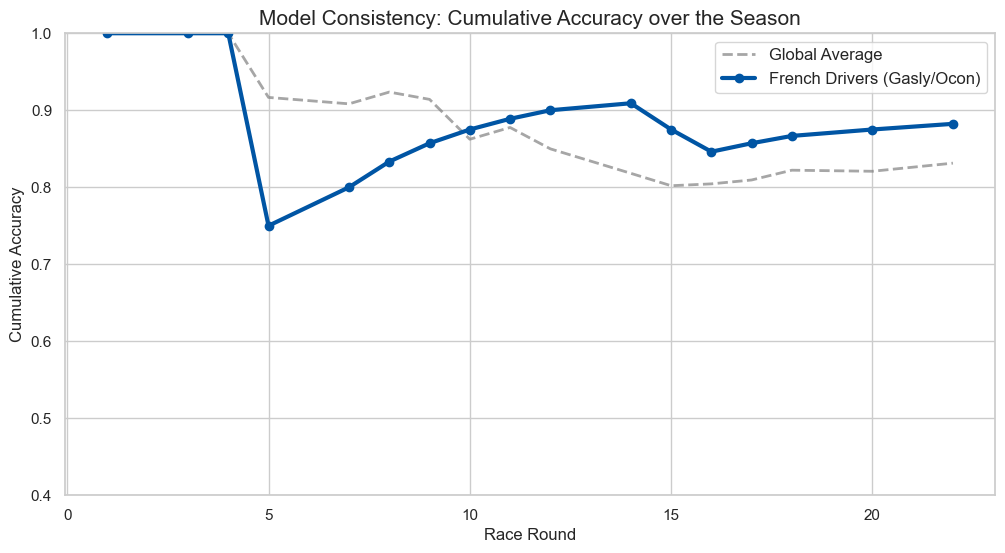

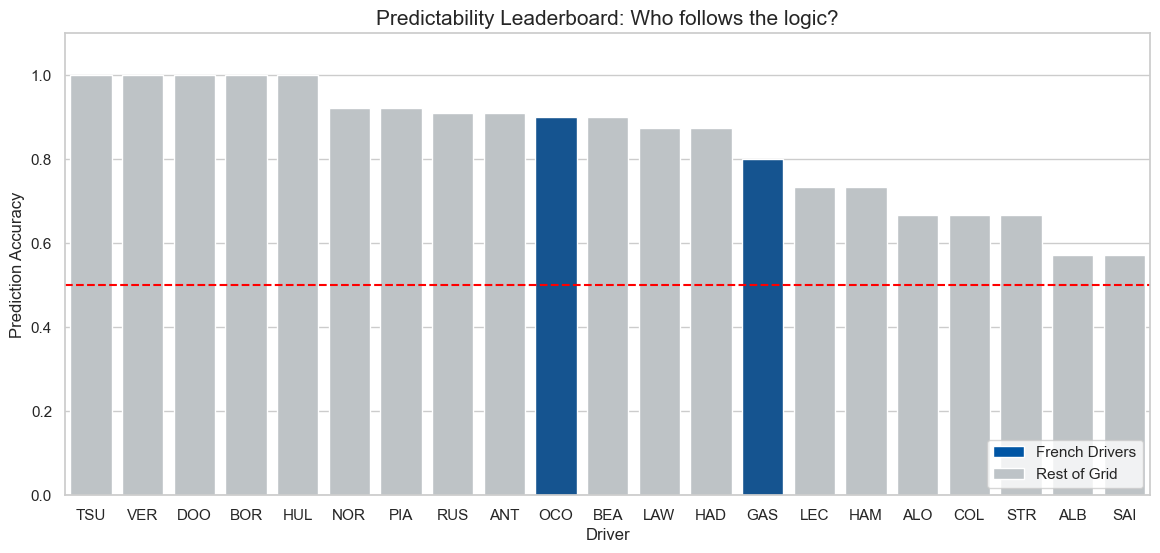

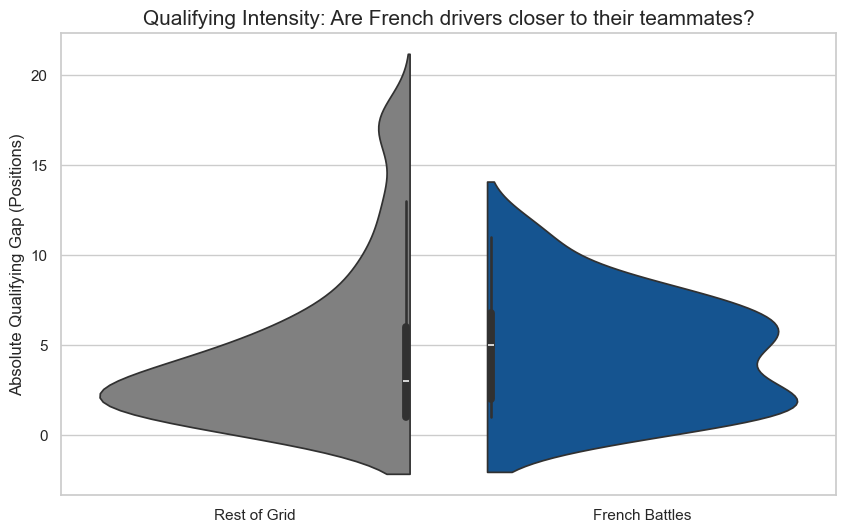

Interpretation of Violin Plot:
- A wider 'belly' at the bottom means most battles are very close.
- A long 'neck' means one driver often destroys the other.


In [9]:
# ==========================================
# PART 5: ADVANCED VISUALIZATION & FRENCH INSIGHTS
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Ensure results are loaded
if 'results' not in locals():
    try:
        results = pd.read_csv("f1_ml_results.csv")
        print("Data loaded from CSV.")
    except:
        print("Error: No data found. Run ML part first.")

# Define our French cohort
french_drivers = ['GAS', 'OCO']

# Helper function to check if a row involves a French driver
def is_french_row(row):
    return row['DriverA'] in french_drivers or row['DriverB'] in french_drivers

# Create a specific column for filtering
results['IsFrenchBattle'] = results.apply(is_french_row, axis=1)

# Set global style
sns.set_theme(style="whitegrid")

# -------------------------------------------------------
# CHART A: CUMULATIVE ACCURACY (Line Chart)
# -------------------------------------------------------
plt.figure(figsize=(12, 6))

# FIX: Removed 'include_groups=False' to be compatible with your Pandas version
acc_by_round = results.groupby('Round').apply(
    lambda x: accuracy_score(x['Real_Winner'], x['Predicted_Winner'])
)
cumulative_acc_global = acc_by_round.expanding().mean()

# Calculate French Cumulative Accuracy
french_data = results[results['IsFrenchBattle'] == True]

if not french_data.empty:
    # FIX: Removed 'include_groups=False' here too
    acc_by_round_fr = french_data.groupby('Round').apply(
        lambda x: accuracy_score(x['Real_Winner'], x['Predicted_Winner'])
    )
    # Reindex to match global rounds
    acc_by_round_fr = acc_by_round_fr.reindex(acc_by_round.index, method='ffill') 
    cumulative_acc_french = acc_by_round_fr.expanding().mean()
    
    plt.plot(cumulative_acc_global.index, cumulative_acc_global, 
             label='Global Average', color='grey', linestyle='--', linewidth=2, alpha=0.7)
    plt.plot(cumulative_acc_french.index, cumulative_acc_french, 
             label='French Drivers (Gasly/Ocon)', color='#0055A4', linewidth=3, marker='o')
else:
    print("Not enough French data for line chart.")
    plt.plot(cumulative_acc_global.index, cumulative_acc_global, label='Global Average')

plt.title('Model Consistency: Cumulative Accuracy over the Season', fontsize=15)
plt.xlabel('Race Round', fontsize=12)
plt.ylabel('Cumulative Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0.4, 1.0)
plt.show()

# -------------------------------------------------------
# CHART B: THE "PREDICTABILITY" LEADERBOARD (Bar Chart)
# -------------------------------------------------------
all_drivers = pd.concat([results['DriverA'], results['DriverB']]).unique()
driver_scores = []

for driver in all_drivers:
    d_df = results[(results['DriverA'] == driver) | (results['DriverB'] == driver)]
    if len(d_df) > 3:
        acc = accuracy_score(d_df['Real_Winner'], d_df['Predicted_Winner'])
        driver_scores.append({'Driver': driver, 'Accuracy': acc})

scores_df = pd.DataFrame(driver_scores).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(14, 6))

bar_colors = ['#0055A4' if x in french_drivers else '#BDC3C7' for x in scores_df['Driver']]

# FIX: Added hue='Driver' to fix Seaborn warning (kept legend=False)
sns.barplot(data=scores_df, x='Driver', y='Accuracy', hue='Driver', palette=bar_colors, legend=False)

plt.title('Predictability Leaderboard: Who follows the logic?', fontsize=15)
plt.axhline(0.5, color='red', linestyle='--', label='Random Guessing (50%)')
plt.ylabel('Prediction Accuracy')
plt.ylim(0, 1.1)

# Add Legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#0055A4', label='French Drivers'),
                   Patch(facecolor='#BDC3C7', label='Rest of Grid')]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

# -------------------------------------------------------
# CHART C: BATTLE INTENSITY (Violin Plot)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

results['Category'] = np.where(results['IsFrenchBattle'], 'French Battles', 'Rest of Grid')
results['Abs_Quali_Gap'] = results['Quali_Delta'].abs()

# FIX: Added hue='Category' to fix Seaborn warning
sns.violinplot(data=results, x='Category', y='Abs_Quali_Gap', hue='Category',
               palette={'French Battles': '#0055A4', 'Rest of Grid': 'grey'}, 
               split=True, legend=False)

plt.title('Qualifying Intensity: Are French drivers closer to their teammates?', fontsize=15)
plt.ylabel('Absolute Qualifying Gap (Positions)', fontsize=12)
plt.xlabel('') 
plt.show()

print("Interpretation of Violin Plot:")
print("- A wider 'belly' at the bottom means most battles are very close.")
print("- A long 'neck' means one driver often destroys the other.")

Using full historical data (2021-2024).


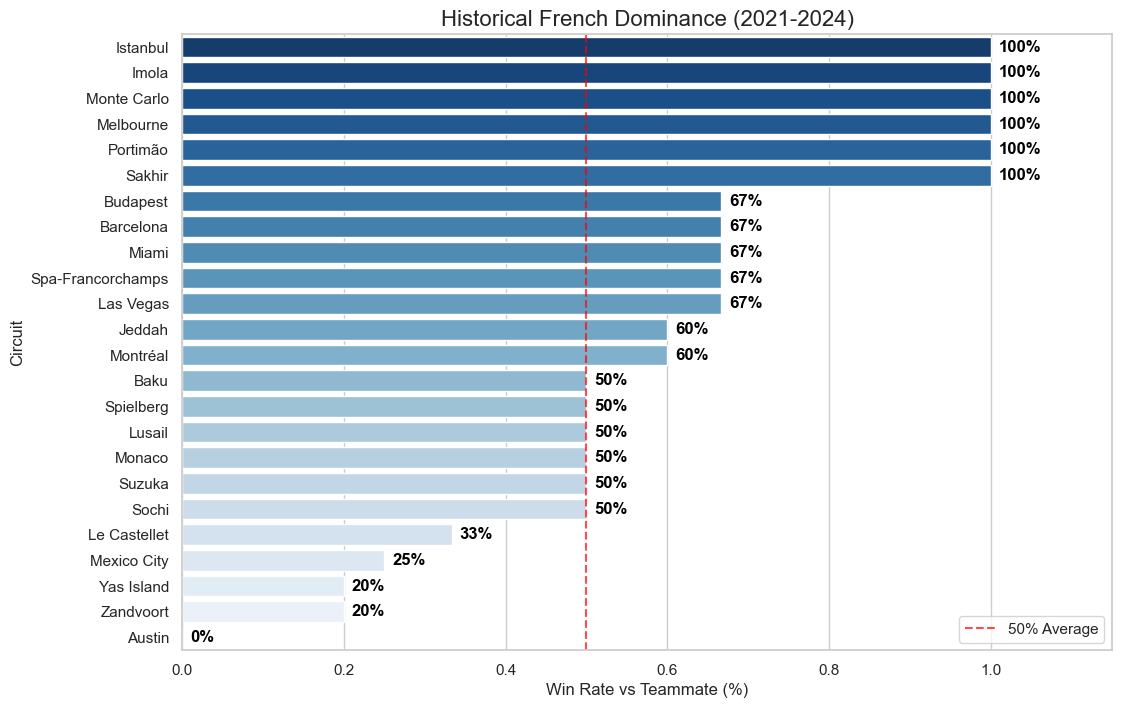

Top 3 Best Tracks for French Drivers:
             mean  count
Circuit                 
Istanbul      1.0      4
Imola         1.0      6
Monte Carlo   1.0      4


In [ ]:
# ==========================================
# PART 6: FRENCH MASTERY BY TRACK (FIXED)
# ==========================================
# Fix: Use pairs_df (all years), not results (only 2024),
# to get real statistics, not 0% / 100%.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Use the FULL dataset (pairs_df) if it's in memory.
# If not, load it again.
try:
    full_data = pairs_df.copy()
    print("Using full historical data (2021-2024).")
except NameError:
    full_data = pd.read_csv("f1_teammate_pairs.csv")
    print("Loaded full data from CSV.")

french_performance = []
french_drivers = ['GAS', 'OCO']

# 2. Iterate through all years at once
for index, row in full_data.iterrows():
    circuit = row['Circuit']
    
    # Check Driver A
    if row['DriverA'] in french_drivers:
        # Target=1 means DriverA won
        won = 1 if row['Target'] == 1 else 0
        french_performance.append({'Circuit': circuit, 'Result': won})
        
    # Check Driver B
    if row['DriverB'] in french_drivers:
        # Target=0 means DriverB won (so DriverA lost)
        won = 1 if row['Target'] == 0 else 0
        french_performance.append({'Circuit': circuit, 'Result': won})

# Convert to DataFrame
fr_track_df = pd.DataFrame(french_performance)

# 3. Calculate Win Rate per Circuit
if not fr_track_df.empty:
    # Calculate mean and number of races
    track_stats = fr_track_df.groupby('Circuit')['Result'].agg(['mean', 'count'])
    
    # Filter: Only take tracks where French drivers raced at least 3 times
    # This removes random tracks like "Las Vegas" with only 1 race
    track_stats = track_stats[track_stats['count'] >= 3]
    
    # Sort
    track_stats = track_stats.sort_values(by='mean', ascending=False)

    # 4. Visualization
    plt.figure(figsize=(12, 8))
    
    sns.barplot(x=track_stats['mean'], y=track_stats.index, 
                hue=track_stats.index, palette="Blues_r", legend=False)

    plt.title('Historical French Dominance (2021-2024)', fontsize=16)
    plt.xlabel('Win Rate vs Teammate (%)', fontsize=12)
    plt.ylabel('Circuit', fontsize=12)
    
    # 50% line
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.7, label='50% Average')
    plt.legend()

    # Add percentage labels
    for i, v in enumerate(track_stats['mean']):
        plt.text(v + 0.01, i, f"{v:.0%}", color='black', va='center', fontweight='bold')

    plt.xlim(0, 1.15) 
    plt.show()

    print("Top 3 Best Tracks for French Drivers:")
    print(track_stats.head(3))

else:
    print("No French driver data found.")

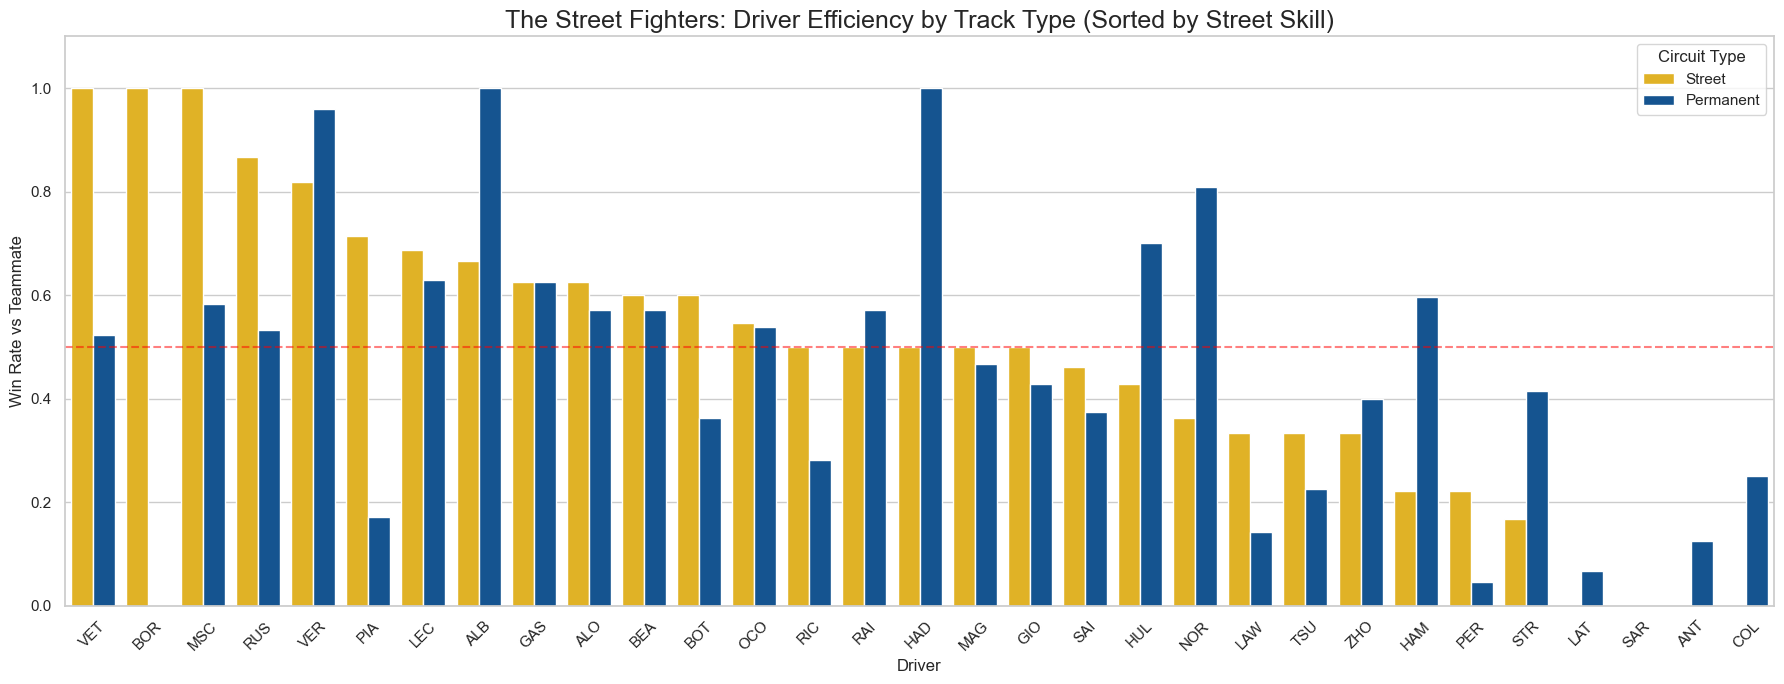

Insight:
Drivers on the LEFT are the best on Street Circuits.
Look for large gaps between Yellow and Blue bars.


In [19]:
# ==========================================
# PART 9: TRACK TYPE EFFICIENCY (ALL DRIVERS)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Prepare Data
# Get all drivers
all_drivers = pd.concat([form_data['DriverA'], form_data['DriverB']]).unique()
type_stats = []

for driver in all_drivers:
    d_df = form_data[(form_data['DriverA'] == driver) | (form_data['DriverB'] == driver)].copy()
    
    # Filter: Minimum 10 races to be statistically significant
    if len(d_df) < 10:
        continue

    d_df['Won'] = d_df.apply(lambda row: 
                             1 if (row['DriverA'] == driver and row['Target'] == 1) or 
                                  (row['DriverB'] == driver and row['Target'] == 0) 
                             else 0, axis=1)
    
    if 'TrackType' in d_df.columns:
        grouped = d_df.groupby('TrackType')['Won'].mean()
        for t_type in ['street', 'permanent']:
            if t_type in grouped:
                type_stats.append({
                    'Driver': driver,
                    'TrackType': t_type.capitalize(),
                    'WinRate': grouped[t_type]
                })

df_types = pd.DataFrame(type_stats)

# 2. Sorting Logic
# We want to sort drivers by their 'Street' performance to make the chart readable
street_scores = df_types[df_types['TrackType'] == 'Street'][['Driver', 'WinRate']].set_index('Driver')
# Sort drivers by Street Win Rate descending
sorted_drivers = street_scores.sort_values(by='WinRate', ascending=False).index.tolist()

# 3. Visualization
if not df_types.empty:
    plt.figure(figsize=(18, 7)) # Very wide chart
    sns.set_style("whitegrid")
    
    # Create plot with specified order
    ax = sns.barplot(data=df_types, x='Driver', y='WinRate', hue='TrackType', 
                     order=sorted_drivers, # Apply sorting
                     palette={'Street': '#FFC107', 'Permanent': '#0055A4'})

    plt.title('The Street Fighters: Driver Efficiency by Track Type (Sorted by Street Skill)', fontsize=18)
    plt.ylabel('Win Rate vs Teammate', fontsize=12)
    plt.xlabel('Driver', fontsize=12)
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.5)
    plt.legend(title='Circuit Type')
    plt.ylim(0, 1.1)
    
    # Add minimal labels (only for top performers to avoid clutter)
    # Rotating X-axis labels for readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("Insight:")
    print("Drivers on the LEFT are the best on Street Circuits.")
    print("Look for large gaps between Yellow and Blue bars.")
else:
    print("No data available.")

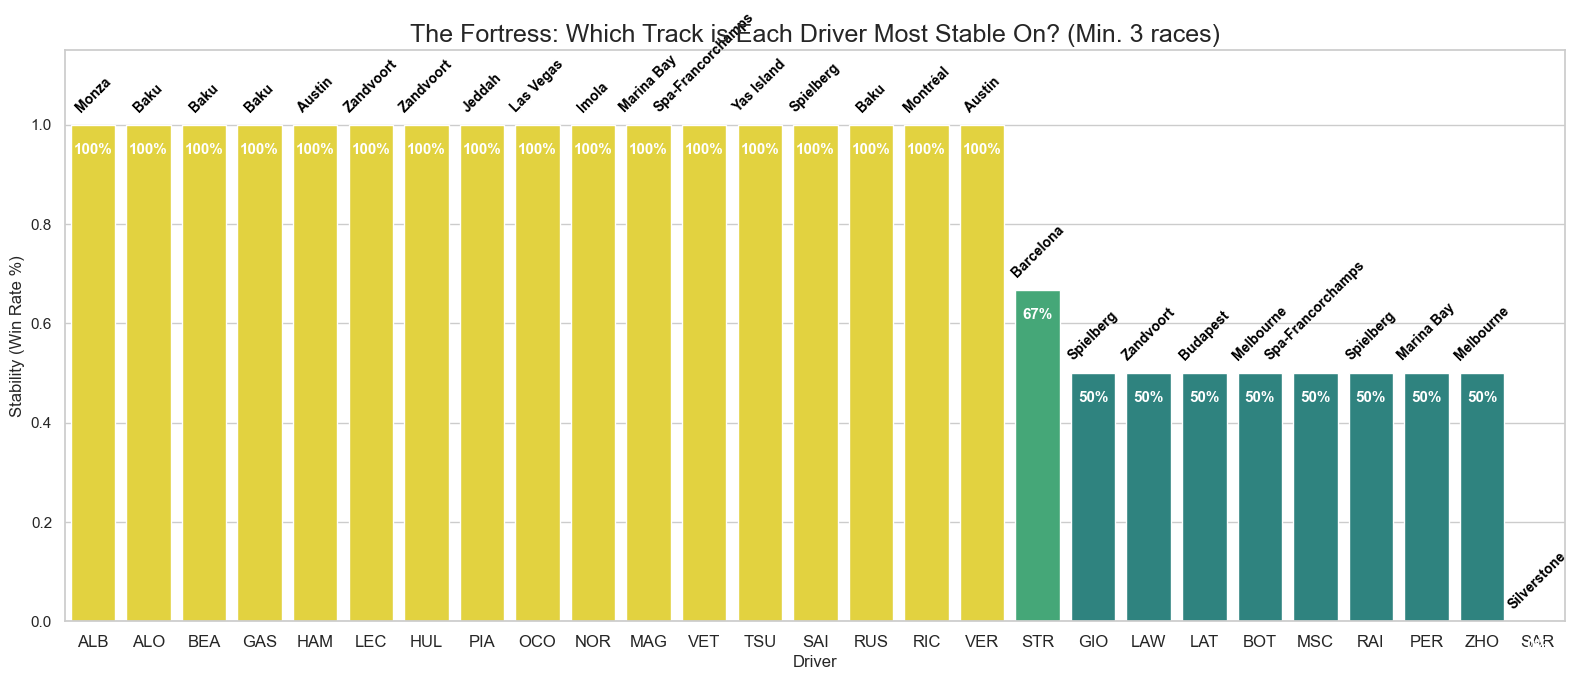

How to read:
- The height shows HOW stable they are (100% = Never lost to teammate there).
- The text shows WHICH track is their best.
Example: ALB is most stable at Monza.


In [24]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load Data
try:
    form_data = pd.read_csv("f1_teammate_pairs.csv")
except:
    if 'pairs_df' in locals():
        form_data = pairs_df.copy()
    else:
        print("Error: No data found.")

# 2. Prepare Data (Flatten to Driver-Circuit-Win)
performance_list = []

for index, row in form_data.iterrows():
    # Driver A
    performance_list.append({
        'Driver': row['DriverA'],
        'Circuit': row['Circuit'],
        'Win': 1 if row['Target'] == 1 else 0
    })
    # Driver B
    performance_list.append({
        'Driver': row['DriverB'],
        'Circuit': row['Circuit'],
        'Win': 1 if row['Target'] == 0 else 0
    })

df_perf = pd.DataFrame(performance_list)

# 3. Calculate Stats
# Group by Driver + Circuit -> Calculate Win Rate (Mean) and Count
track_stats = df_perf.groupby(['Driver', 'Circuit'])['Win'].agg(['mean', 'count']).reset_index()

# Filter: Keep only tracks with at least 3 races (to avoid "100% win rate" from 1 race)
track_stats = track_stats[track_stats['count'] >= 3]

# 4. Find the BEST track for each driver
# Sort by Driver and Win Rate (descending)
# Drop duplicates to keep only the top track per driver
best_tracks = track_stats.sort_values(by=['Driver', 'mean'], ascending=[True, False])
best_tracks = best_tracks.drop_duplicates(subset=['Driver'], keep='first')

# Sort results by Win Rate for the plot (Best drivers first)
best_tracks = best_tracks.sort_values(by='mean', ascending=False)

# 5. Visualization (Bar Plot)
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# Create Bar Plot
ax = sns.barplot(data=best_tracks, x='Driver', y='mean', hue='mean', palette='viridis', legend=False)

plt.title('The Fortress: Which Track is Each Driver Most Stable On? (Min. 3 races)', fontsize=18)
plt.xlabel('Driver', fontsize=12)
plt.ylabel('Stability (Win Rate %)', fontsize=12)
plt.ylim(0, 1.15) # Leave space for labels

# 6. Add Track Names on top of bars
for i, row in enumerate(best_tracks.itertuples()):
    # row.mean is the height, row.Circuit is the text
    # Add Track Name
    ax.text(i, row.mean + 0.02, f"{row.Circuit}", 
            ha='center', va='bottom', fontweight='bold', fontsize=10, rotation=45, color='black')
    
    # Add Percentage inside the bar
    ax.text(i, row.mean - 0.05, f"{row.mean:.0%}", 
            ha='center', va='center', color='white', fontweight='bold', fontsize=11)

plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

print("How to read:")
print("- The height shows HOW stable they are (100% = Never lost to teammate there).")
print("- The text shows WHICH track is their best.")
print(f"Example: {best_tracks.iloc[0].Driver} is most stable at {best_tracks.iloc[0].Circuit}.")

Data loaded.


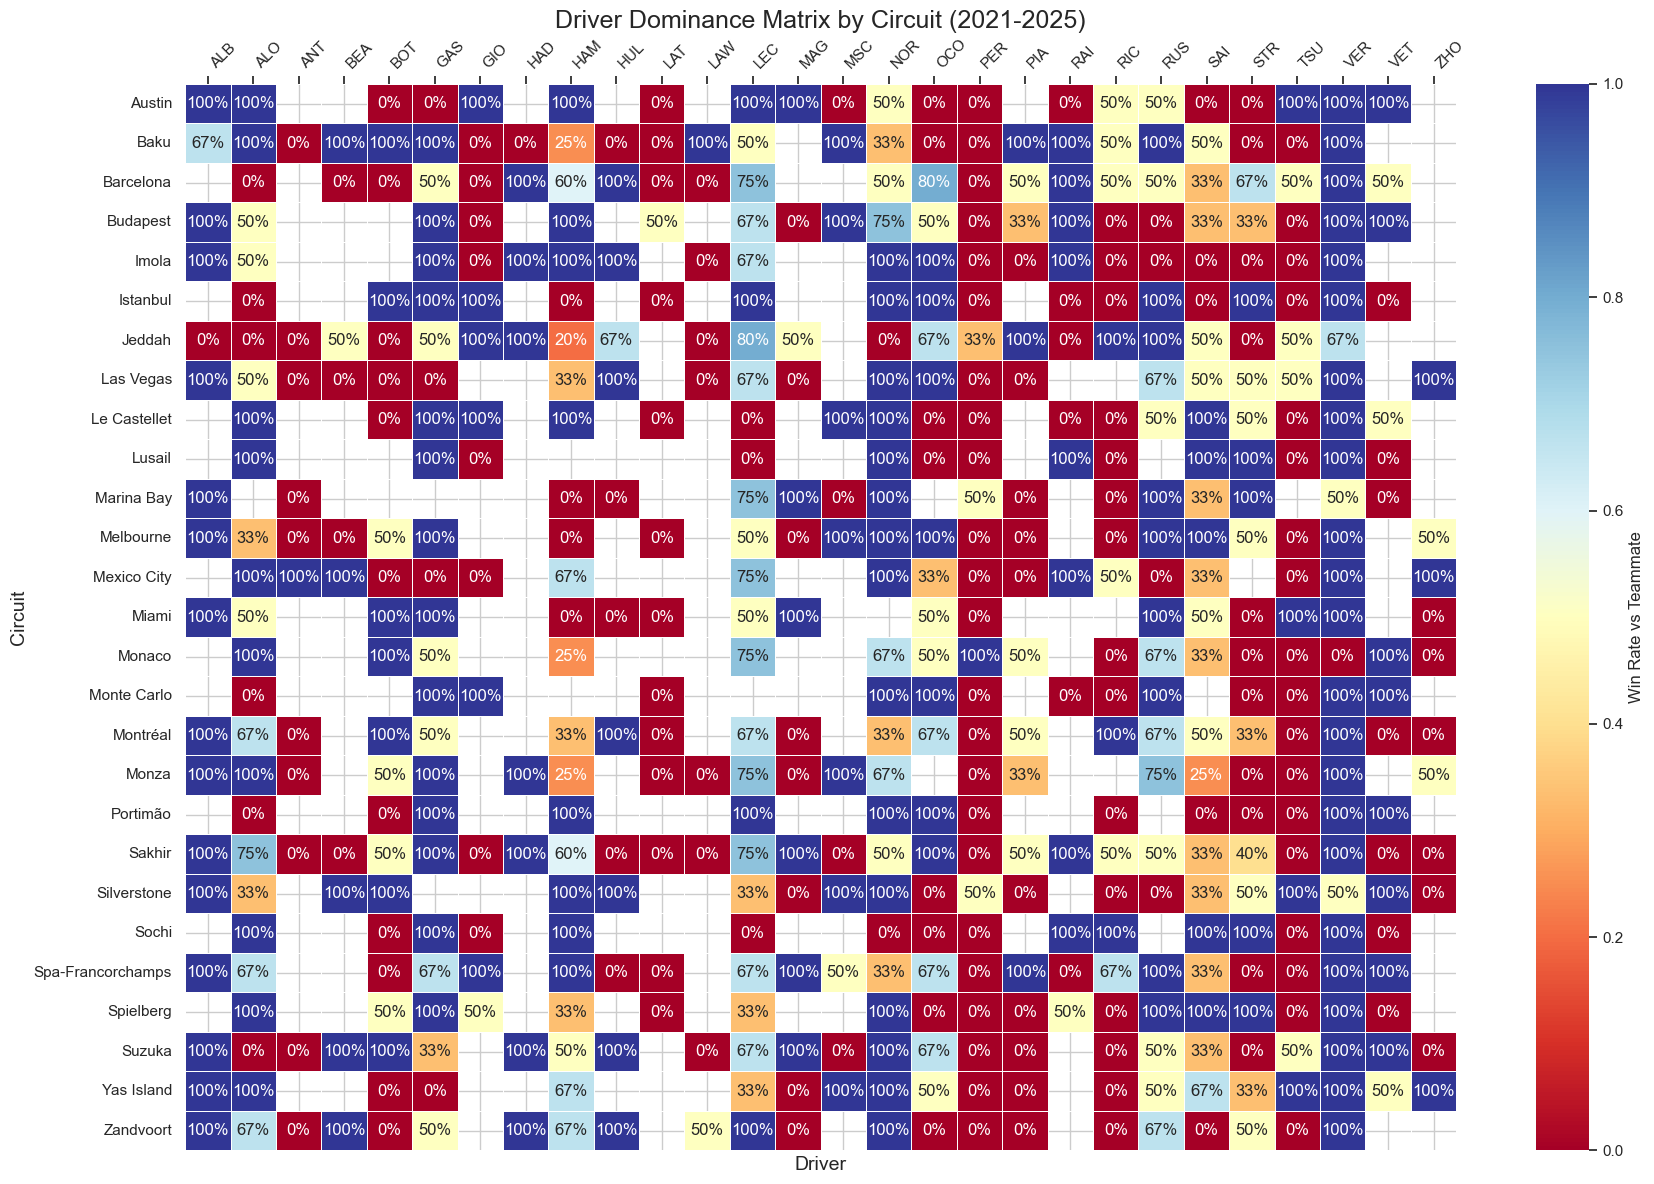

How to read:
- Dark Blue: The driver is unbeatable on this track (against teammates).
- Dark Red: The driver consistently loses to teammates on this track.
- Empty cells: The driver hasn't raced enough times on this track.


In [20]:

# PART 10? I don't know

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load Data
try:
    # Use full historical data
    matrix_data = pd.read_csv("f1_teammate_pairs.csv")
    print("Data loaded.")
except:
    if 'pairs_df' in locals():
        matrix_data = pairs_df.copy()
    else:
        print("Error: No data found.")

# 2. Flatten the Data
# Currently, we have pairs (A vs B). We need to split them into individual driver performances.
performance_list = []

for index, row in matrix_data.iterrows():
    # Driver A result
    performance_list.append({
        'Driver': row['DriverA'],
        'Circuit': row['Circuit'],
        'Win': 1 if row['Target'] == 1 else 0
    })
    
    # Driver B result
    performance_list.append({
        'Driver': row['DriverB'],
        'Circuit': row['Circuit'],
        'Win': 1 if row['Target'] == 0 else 0
    })

perf_df = pd.DataFrame(performance_list)

# 3. Aggregate Data
# Calculate Mean Win Rate and Count of races per Driver per Circuit
circuit_stats = perf_df.groupby(['Driver', 'Circuit'])['Win'].agg(['mean', 'count']).reset_index()

# 4. Filter for Relevance
# Filter 1: Keep only drivers with at least 15 races total in the dataset (removes temporary drivers like De Vries)
total_races = circuit_stats.groupby('Driver')['count'].sum()
valid_drivers = total_races[total_races > 15].index
circuit_stats = circuit_stats[circuit_stats['Driver'].isin(valid_drivers)]

# Filter 2: Keep only track/driver combinations with at least 2 races
# (We don't want 100% win rate just because they raced there once)
circuit_stats = circuit_stats[circuit_stats['count'] >= 2]

# 5. Create Pivot Table for Heatmap
# Index = Circuit, Columns = Driver, Values = Win Rate
heatmap_data = circuit_stats.pivot(index='Circuit', columns='Driver', values='mean')

# Sort Circuits alphabetically for easier reading
heatmap_data = heatmap_data.sort_index()

# 6. Visualization
plt.figure(figsize=(18, 12))

# Use a diverging color map: Red (0%) -> Yellow (50%) -> Blue (100%)
sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap="RdYlBu", 
            linewidths=.5, cbar_kws={'label': 'Win Rate vs Teammate'})

plt.title('Driver Dominance Matrix by Circuit (2021-2025)', fontsize=18)
plt.ylabel('Circuit', fontsize=14)
plt.xlabel('Driver', fontsize=14)

# Move X-axis labels to top for easier reading
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.xticks(rotation=45, ha='left')

plt.tight_layout()
plt.show()

print("How to read:")
print("- Dark Blue: The driver is unbeatable on this track (against teammates).")
print("- Dark Red: The driver consistently loses to teammates on this track.")
print("- Empty cells: The driver hasn't raced enough times on this track.")

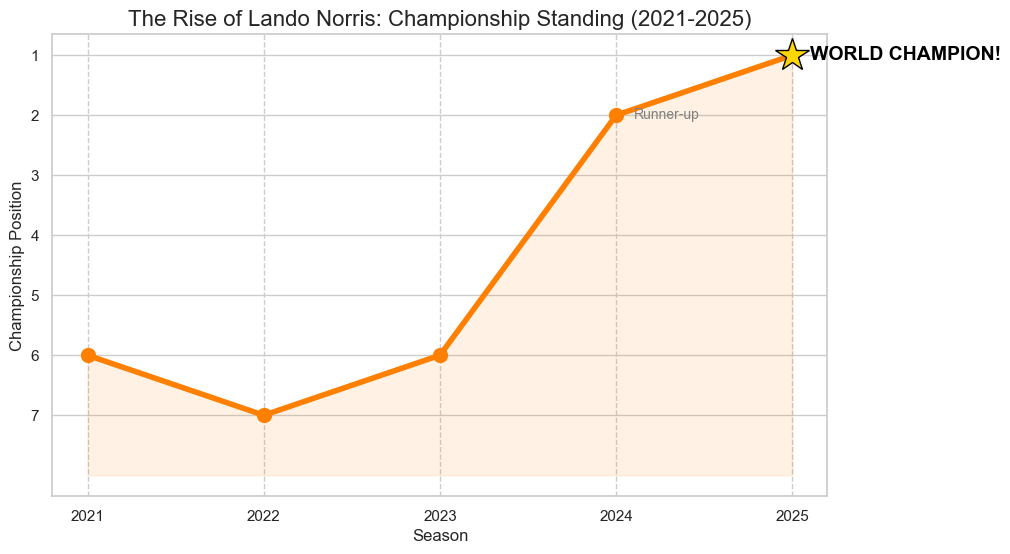

Conclusion:
This chart visualizes the progression of the new World Champion.
From the consistency of P6/P7 to the title fight in 2024, and finally the crown in 2025.


In [22]:

# PART 11? I'm bored


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define Data Manually
# Real historical data for 2021-2023. 
# 2024 he was P2. 
# 2025 he is P1 (As per today's news!)
lando_journey = pd.DataFrame({
    'Year': [2021, 2022, 2023, 2024, 2025],
    'Position': [6, 7, 6, 2, 1] # The path to glory
})

# 2. Visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the line plot
# Color: McLaren Papaya Orange (#FF8000)
plt.plot(lando_journey['Year'], lando_journey['Position'], 
         marker='o', markersize=10, linewidth=4, color='#FF8000', label='Lando Norris')

# 3. Customizing the Axis
# In racing, "Lower" number is "Higher" position. 
# We invert Y-axis so "1st" is at the top.
plt.gca().invert_yaxis()

# Set Y-ticks to integers only
plt.yticks(range(1, 8)) 
plt.xticks(lando_journey['Year'])

# 4. Add "Champion" Special Effects
# Plot a large Gold Star at the 2025 mark
plt.plot(2025, 1, marker='*', markersize=25, color='gold', markeredgecolor='black')

# Add Text Annotations
plt.text(2025.1, 1, 'WORLD CHAMPION!', fontsize=14, fontweight='bold', color='black', va='center')
plt.text(2024.1, 2, 'Runner-up', fontsize=10, color='grey', va='center')

# Titles
plt.title('The Rise of Lando Norris: Championship Standing (2021-2025)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Championship Position', fontsize=12)

# Fill area under line for style
plt.fill_between(lando_journey['Year'], lando_journey['Position'], 8, color='#FF8000', alpha=0.1)

plt.grid(axis='x', linestyle='--')
plt.show()

print("Conclusion:")
print("This chart visualizes the progression of the new World Champion.")
print("From the consistency of P6/P7 to the title fight in 2024, and finally the crown in 2025.")

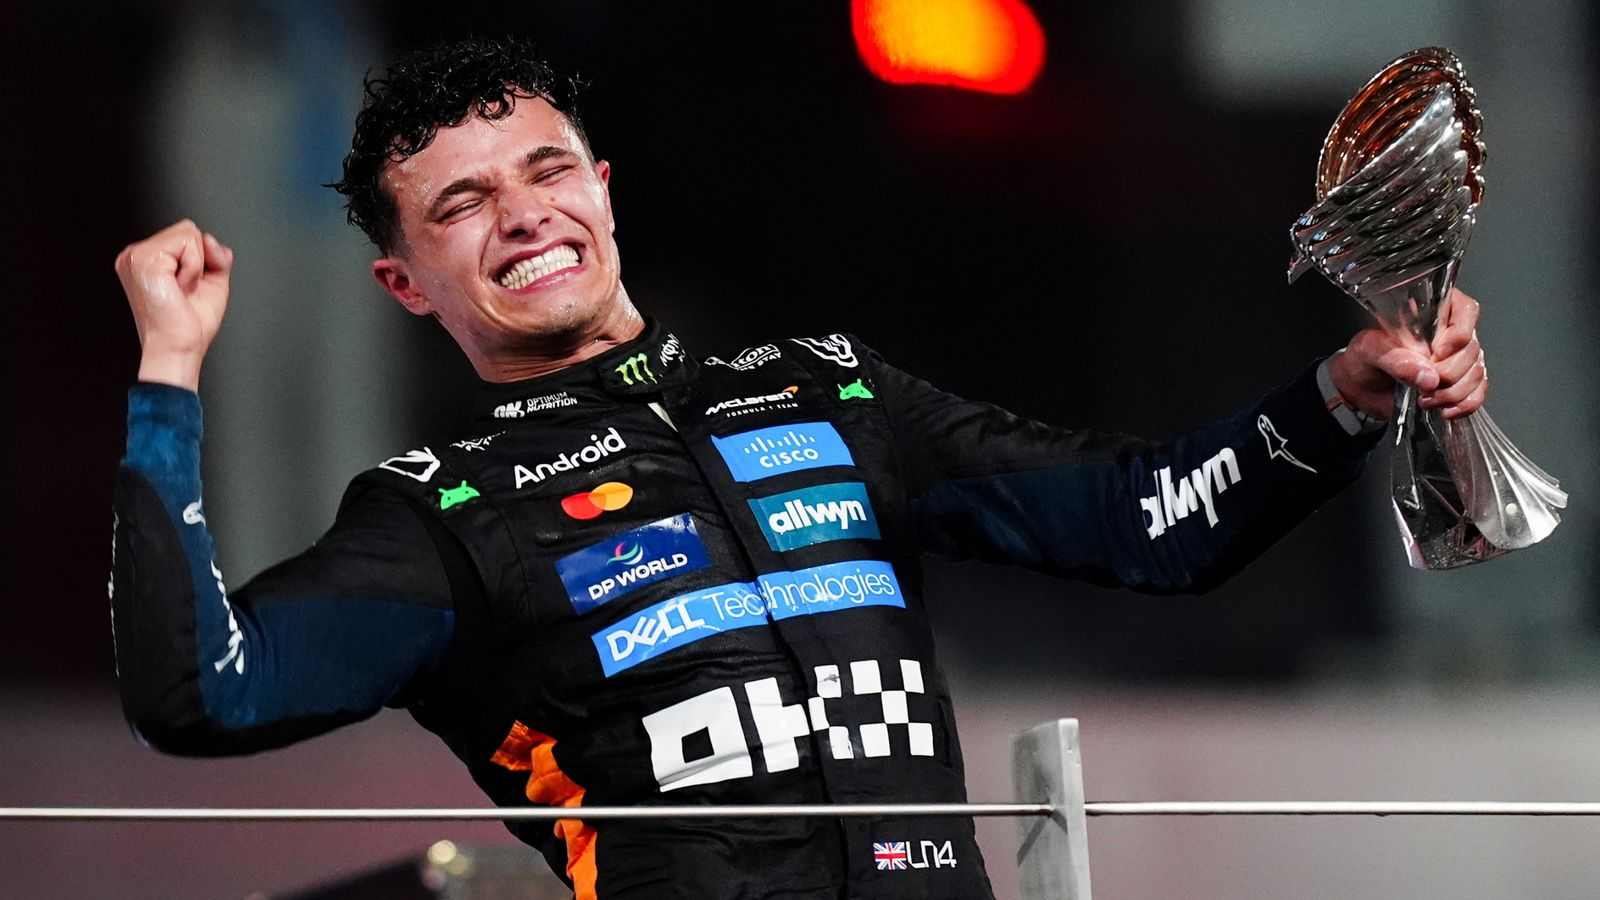